# Library dan Dependensi 

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN
import time
import io
import base64

# Enable eager execution for compatibility
tf.config.run_functions_eagerly(True)

# Import Data

In [2]:
data = pd.read_csv('../data/fetal_health.csv')

# Eksplorasi Data

In [3]:
# Data Exploration
print("Shape of data:", data.shape)
print(data.head())
print(data.info())
print(data.describe())
print("Class distribution:")
print(data.iloc[:, -1].value_counts())

Shape of data: (2126, 22)
   baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0       

# Praproses Data

## Splitting

In [31]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# banyak train dan test 
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1700, 21)
Test set shape: (426, 21)


### Distribusi Kelas Train Sebelum SMOTE-ENN

In [33]:
# Tampilkan distribusi kelas sebelum SMOTE-ENN
print("="*50)
print("DISTRIBUSI KELAS SEBELUM SMOTE-ENN")
print("="*50)
unique, counts = np.unique(y_train, return_counts=True)
total_samples = len(y_train)

for i, (cls, count) in enumerate(zip(unique, counts)):
    percentage = count/total_samples*100
    print(f"Kelas {cls}: {count:,} samples ({percentage:.2f}%)")

print("-"*50)
print(f"Total samples: {total_samples:,}")
print("="*50)

DISTRIBUSI KELAS SEBELUM SMOTE-ENN
Kelas 0: 1,322 samples (77.76%)
Kelas 1: 231 samples (13.59%)
Kelas 2: 147 samples (8.65%)
--------------------------------------------------
Total samples: 1,700


## SMOTE-ENN

In [34]:
# SMOTE-ENN hanya di training
smote_enn = SMOTEENN(random_state=42)
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

### Distribusi Kelas Train Setelah SMOTE-ENN

In [35]:
# Tampilkan distribusi kelas setelah SMOTE-ENN
print("="*50)
print("DISTRIBUSI KELAS SETELAH SMOTE-ENN")
print("="*50)
unique_after, counts_after = np.unique(y_train, return_counts=True)
total_samples_after = len(y_train)

for i, (cls, count) in enumerate(zip(unique_after, counts_after)):
    percentage = count/total_samples_after*100
    print(f"Kelas {cls}: {count:,} samples ({percentage:.2f}%)")

print("-"*50)
print(f"Total samples: {total_samples_after:,}")
print("="*50)

DISTRIBUSI KELAS SETELAH SMOTE-ENN
Kelas 0: 1,095 samples (30.15%)
Kelas 1: 1,253 samples (34.50%)
Kelas 2: 1,284 samples (35.35%)
--------------------------------------------------
Total samples: 3,632


## Normalisasi

In [12]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Eksperimen

In [ ]:
# Daftar konfigurasi untuk eksperimen dengan learning rate yang sama (0.001)
learning_rate = 0.001
optimizers = ['adam', 'sgd', 'rmsprop']
activations = ['relu', 'tanh', 'sigmoid']

# Simpan hasil eksperimen
results = []

for opt_name in optimizers:
    for act in activations:
        print(f"\n--- Eksperimen: Optimizer={opt_name}, Activation={act} ---")
        
        # Buat model
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(X_train.shape[1],)),
            layers.Dense(16, activation=act),
            layers.Dense(len(np.unique(y)), activation='softmax')
        ])
        
        # Buat optimizer baru untuk setiap model
        if opt_name == 'adam':
            opt_obj = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        elif opt_name == 'sgd':
            opt_obj = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        elif opt_name == 'rmsprop':
            opt_obj = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        
        # Compile model
        model.compile(optimizer=opt_obj,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Train model
        start_time = time.time()
        history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
        end_time = time.time()
        runtime = end_time - start_time
        
        # Evaluate
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
        
        # Compute predictions and classification report
        y_pred = model.predict(X_test, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        report = classification_report(y_test, y_pred_classes, output_dict=True)
        
        # Extract macro averages
        precision = report['macro avg']['precision']
        recall = report['macro avg']['recall']
        f1_score = report['macro avg']['f1-score']
        
        # Simpan hasil
        results.append({
            'optimizer': opt_name,
            'activation': act,
            'test_accuracy': test_acc,
            'test_loss': test_loss,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'runtime': runtime,
            'history': history.history
        })
        
        print(f"Test Accuracy: {test_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}, Runtime: {runtime:.2f} seconds")


--- Eksperimen: Optimizer=adam, Activation=relu ---


d:\anaconda3\envs\tfcpu\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Test Accuracy: 0.8169, Precision: 0.6777, Recall: 0.8211, F1-Score: 0.7232, Runtime: 36.59 seconds

--- Eksperimen: Optimizer=adam, Activation=tanh ---


d:\anaconda3\envs\tfcpu\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Test Accuracy: 0.8263, Precision: 0.6934, Recall: 0.8125, F1-Score: 0.7318, Runtime: 40.85 seconds

--- Eksperimen: Optimizer=adam, Activation=sigmoid ---


d:\anaconda3\envs\tfcpu\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Test Accuracy: 0.7887, Precision: 0.6451, Recall: 0.7755, F1-Score: 0.6798, Runtime: 31.08 seconds

--- Eksperimen: Optimizer=sgd, Activation=relu ---


d:\anaconda3\envs\tfcpu\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Test Accuracy: 0.7136, Precision: 0.5773, Recall: 0.7519, F1-Score: 0.6092, Runtime: 23.40 seconds

--- Eksperimen: Optimizer=sgd, Activation=tanh ---


d:\anaconda3\envs\tfcpu\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Test Accuracy: 0.5681, Precision: 0.5358, Recall: 0.6625, F1-Score: 0.5150, Runtime: 26.15 seconds

--- Eksperimen: Optimizer=sgd, Activation=sigmoid ---


d:\anaconda3\envs\tfcpu\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
d:\anaconda3\envs\tfcpu\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\anaconda3\envs\tfcpu\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

Test Accuracy: 0.4742, Precision: 0.3657, Recall: 0.4504, F1-Score: 0.3125, Runtime: 18.89 seconds

--- Eksperimen: Optimizer=rmsprop, Activation=relu ---
Test Accuracy: 0.8286, Precision: 0.6931, Recall: 0.8324, F1-Score: 0.7392, Runtime: 57.32 seconds

--- Eksperimen: Optimizer=rmsprop, Activation=tanh ---
Test Accuracy: 0.8286, Precision: 0.6931, Recall: 0.8324, F1-Score: 0.7392, Runtime: 57.32 seconds

--- Eksperimen: Optimizer=rmsprop, Activation=tanh ---


d:\anaconda3\envs\tfcpu\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Test Accuracy: 0.8404, Precision: 0.7070, Recall: 0.8437, F1-Score: 0.7529, Runtime: 69.75 seconds

--- Eksperimen: Optimizer=rmsprop, Activation=sigmoid ---


d:\anaconda3\envs\tfcpu\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Test Accuracy: 0.8075, Precision: 0.6751, Recall: 0.8087, F1-Score: 0.7137, Runtime: 80.51 seconds


# Evaluasi  
- Dapatkan kombinasi konfigurasi terbaik dari eksperimen  
- Bangun ulang model dengan konfigurasi terbaik
- Latih kembali model  
- Tampilkan performa  
- Tampilkan classification report

In [19]:
# cari konfigurasi terbaik berdasarkan test accuracy
df_results = pd.DataFrame(results)
best_idx = df_results['test_accuracy'].idxmax()
best_config = df_results.iloc[best_idx]

print(f"Konfigurasi Terbaik: Optimizer={best_config['optimizer']}, Activation={best_config['activation']}")
print(f"Test Accuracy: {best_config['test_accuracy']:.4f}")

Konfigurasi Terbaik: Optimizer=rmsprop, Activation=tanh
Test Accuracy: 0.8404


In [20]:
# bangun kembali model terbaik
best_model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(16, activation=best_config['activation']),
    layers.Dense(len(np.unique(y)), activation='softmax')
])

In [21]:
# atur optimizer sesuai konfigurasi terbaik
learning_rate = 0.001
if best_config['optimizer'] == 'adam':
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif best_config['optimizer'] == 'sgd':
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
elif best_config['optimizer'] == 'rmsprop':
    opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

best_model.compile(optimizer=opt,
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
# latih kembali model
history = best_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

d:\anaconda3\envs\tfcpu\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [23]:
# evaluasi pada test data
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8451 - loss: 0.4422
Test accuracy: 0.8450704216957092


In [24]:
# Predictions
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(cm)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       0.99      0.83      0.90       333
           1       0.54      0.92      0.68        64
           2       0.65      0.83      0.73        29

    accuracy                           0.85       426
   macro avg       0.73      0.86      0.77       426
weighted avg       0.90      0.85      0.86       426

Confusion Matrix:
[[277  46  10]
 [  2  59   3]
 [  1   4  24]]


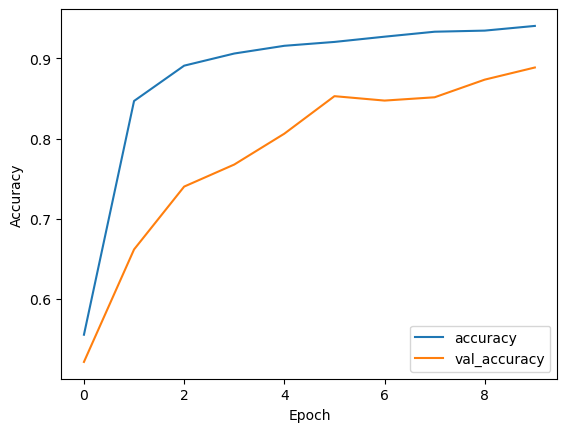

In [25]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Ringkasan Eksperimen

Tabel Performa Model:
  optimizer activation  test_accuracy  test_loss  precision    recall  \
0      adam       relu       0.816901   0.474615   0.677674  0.821096   
1      adam       tanh       0.826291   0.445093   0.693362  0.812529   
2      adam    sigmoid       0.788732   0.482804   0.645148  0.775526   
3       sgd       relu       0.713615   0.674294   0.577261  0.751859   
4       sgd       tanh       0.568075   0.888385   0.535835  0.662524   
5       sgd    sigmoid       0.474178   1.014676   0.365714  0.450435   
6   rmsprop       relu       0.828638   0.485511   0.693082  0.832387   
7   rmsprop       tanh       0.840376   0.444338   0.707028  0.843728   
8   rmsprop    sigmoid       0.807512   0.478899   0.675052  0.808728   

   f1_score    runtime  
0  0.723231  36.591542  
1  0.731763  40.848961  
2  0.679824  31.076247  
3  0.609154  23.403873  
4  0.515038  26.150338  
5  0.312472  18.885528  
6  0.739152  57.322273  
7  0.752862  69.754827  
8  0.713715  80.513677

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13592\3833571005.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


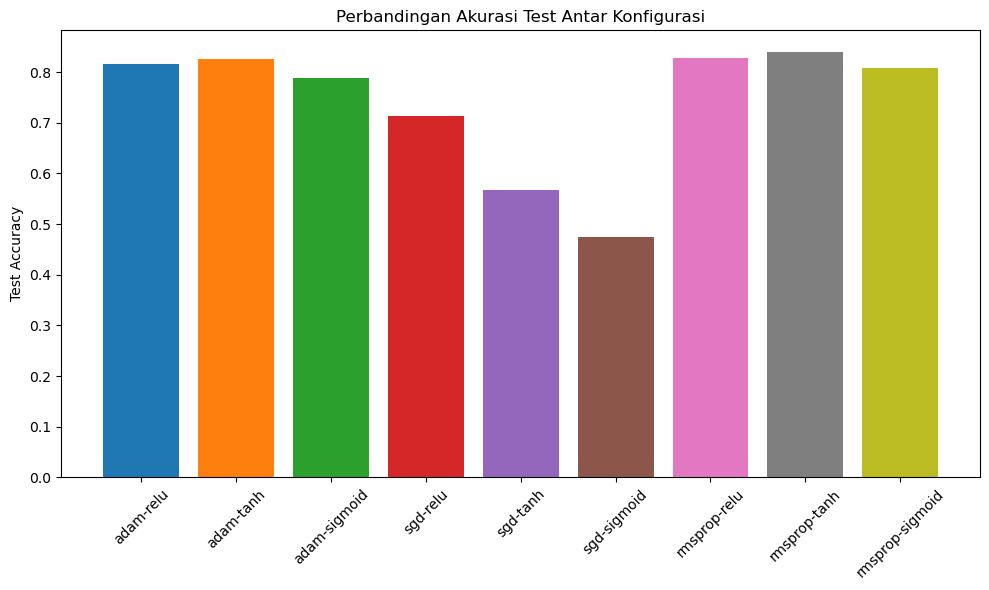


Konfigurasi Terbaik: Optimizer=rmsprop, Activation=tanh, Accuracy=0.8404, Precision=0.7070, Recall=0.8437, F1-Score=0.7529, Runtime=69.75 seconds


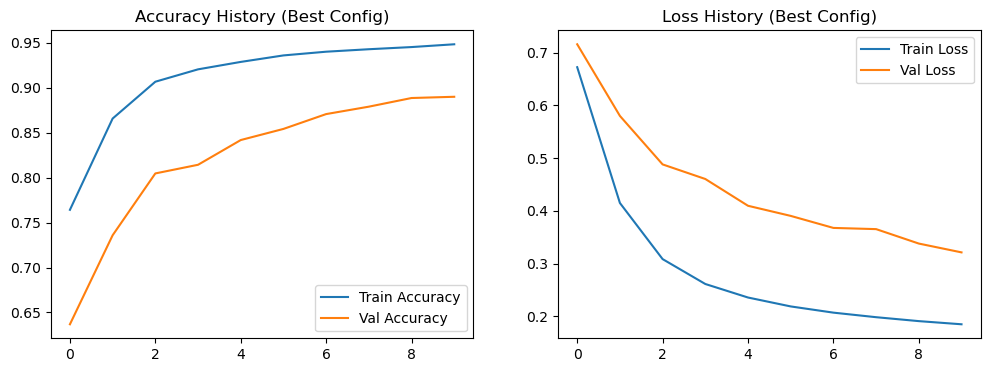

In [26]:
# Buat DataFrame dari hasil
df_results = pd.DataFrame(results)
print("Tabel Performa Model:")
print(df_results[['optimizer', 'activation', 'test_accuracy', 'test_loss', 'precision', 'recall', 'f1_score', 'runtime']])

# Plot perbandingan akurasi
fig, ax = plt.subplots(figsize=(10, 6))
for i, row in df_results.iterrows():
    label = f"{row['optimizer']}-{row['activation']}"
    ax.bar(label, row['test_accuracy'], label=label)

ax.set_ylabel('Test Accuracy')
ax.set_title('Perbandingan Akurasi Test Antar Konfigurasi')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

# Plot loss untuk konfigurasi terbaik (opsional)
best_idx = df_results['test_accuracy'].idxmax()
best_config = df_results.iloc[best_idx]
print(f"\nKonfigurasi Terbaik: Optimizer={best_config['optimizer']}, Activation={best_config['activation']}, Accuracy={best_config['test_accuracy']:.4f}, Precision={best_config['precision']:.4f}, Recall={best_config['recall']:.4f}, F1-Score={best_config['f1_score']:.4f}, Runtime={best_config['runtime']:.2f} seconds")

# Plot history untuk konfigurasi terbaik
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(best_config['history']['accuracy'], label='Train Accuracy')
plt.plot(best_config['history']['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy History (Best Config)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_config['history']['loss'], label='Train Loss')
plt.plot(best_config['history']['val_loss'], label='Val Loss')
plt.title('Loss History (Best Config)')
plt.legend()
plt.show()

# HTML Report

NameError: name 'HTML' is not defined

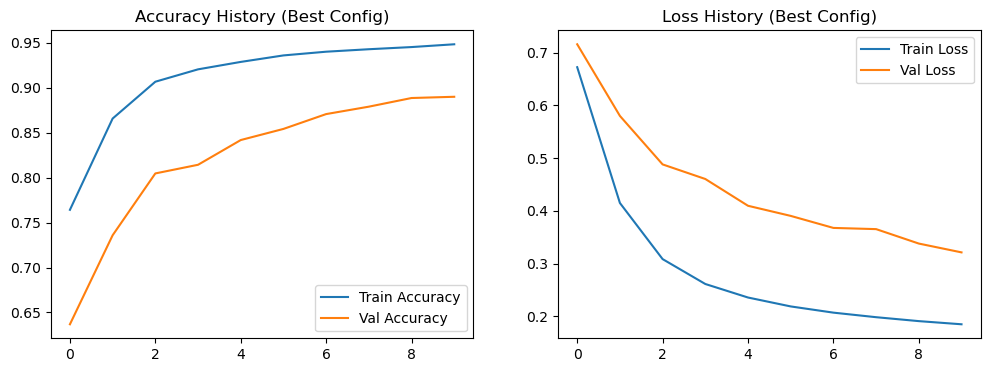

In [18]:
# Fungsi untuk mengkonversi plot ke base64
def plot_to_base64(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    image_base64 = base64.b64encode(buf.read()).decode('utf-8')
    buf.close()
    return f"data:image/png;base64,{image_base64}"

# Buat HTML laporan
html = """
<h1>Laporan Hasil Klasifikasi</h1>

<h2>Arsitektur Model</h2>
<p>Model menggunakan arsitektur Sequential dengan layer-layer berikut:</p>
<ul>
    <li>Input(shape=(X_train.shape[1],))</li>
    <li>Dense(16, activation=activation_function)</li>
    <li>Dense(len(np.unique(y)), activation='softmax')</li>
</ul>

<h2>Parameter yang Dicoba</h2>
<p>Eksperimen dilakukan dengan kombinasi parameter berikut:</p>
<ul>
    <li><strong>Optimizer:</strong> adam, sgd, rmsprop (semua dengan learning rate 0.001)</li>
    <li><strong>Activation Function:</strong> relu, tanh, sigmoid</li>
    <li><strong>Epochs:</strong> 10</li>
    <li><strong>Batch Size:</strong> 32</li>
    <li><strong>Validation Split:</strong> 0.2</li>
</ul>

<h2>Hasil Setiap Percobaan</h2>
<table border="1" style="border-collapse: collapse; width: 100%;">
    <tr>
        <th>Optimizer</th>
        <th>Activation</th>
        <th>Test Accuracy</th>
        <th>Test Loss</th>
        <th>Precision</th>
        <th>Recall</th>
        <th>F1-Score</th>
        <th>Runtime (seconds)</th>
    </tr>
"""

for _, row in df_results.iterrows():
    html += f"""
    <tr>
        <td>{row['optimizer']}</td>
        <td>{row['activation']}</td>
        <td>{row['test_accuracy']:.4f}</td>
        <td>{row['test_loss']:.4f}</td>
        <td>{row['precision']:.4f}</td>
        <td>{row['recall']:.4f}</td>
        <td>{row['f1_score']:.4f}</td>
        <td>{row['runtime']:.2f}</td>
    </tr>
"""

html += """
</table>

<h2>Konfigurasi Terbaik</h2>
<p>Konfigurasi terbaik berdasarkan test accuracy tertinggi:</p>
<ul>
    <li><strong>Optimizer:</strong> """ + str(best_config['optimizer']) + """</li>
    <li><strong>Activation:</strong> """ + str(best_config['activation']) + """</li>
    <li><strong>Test Accuracy:</strong> """ + f"{best_config['test_accuracy']:.4f}" + """</li>
    <li><strong>Test Loss:</strong> """ + f"{best_config['test_loss']:.4f}" + """</li>
    <li><strong>Precision:</strong> """ + f"{best_config['precision']:.4f}" + """</li>
    <li><strong>Recall:</strong> """ + f"{best_config['recall']:.4f}" + """</li>
    <li><strong>F1-Score:</strong> """ + f"{best_config['f1_score']:.4f}" + """</li>
    <li><strong>Runtime:</strong> """ + f"{best_config['runtime']:.2f} seconds" + """</li>
</ul>

<h2>Grafik Perbandingan Akurasi</h2>
<img src=\"""" + plot_to_base64(fig) + """\" alt="Perbandingan Akurasi" style="width:100%; max-width:800px;">

<h2>History Training untuk Konfigurasi Terbaik</h2>
"""

# Buat plot history lagi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(best_config['history']['accuracy'], label='Train Accuracy')
plt.plot(best_config['history']['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy History (Best Config)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_config['history']['loss'], label='Train Loss')
plt.plot(best_config['history']['val_loss'], label='Val Loss')
plt.title('Loss History (Best Config)')
plt.legend()
history_fig = plt.gcf()
html += """<img src=\"""" + plot_to_base64(history_fig) + """\" alt="History Training" style="width:100%; max-width:800px;">"""

html += """
</body>
</html>
"""

display(HTML(html))

In [ ]:
# simpan laporan ke file HTML
with open('report_fetal_v2.html', 'w') as f:
    f.write(html)

In [ ]:
best_model.save('best_fetal_model.keras')